In [1]:
import numpy as np
import pandas as pd
import datetime

In [2]:
def find_index(name, m_date):
    index = 0
    while name['TRADEDATE'][index] < m_date:
        index += 1
    
    return index

# groups info about stock, RGBI and IMOEX in convenient way 

In [3]:
rgbi_info = pd.read_csv(f"benchmarks/RGBI.csv")
imoex_info = pd.read_csv(f"benchmarks/IMOEX.csv")
share_indexes = pd.read_csv('additional_info/share_indexes.csv')

for curr_ticker in share_indexes['TICKERS']:
    whole_share_info = pd.read_csv(f"stock_history/{curr_ticker}_history.csv")

    rgbi_index = 0
    imoex_index = 0
    share_index = 0

    if (rgbi_info['TRADEDATE'][0]) > (whole_share_info['TRADEDATE'][0]):
        min_date = rgbi_info['TRADEDATE'][0]
        share_index = find_index(whole_share_info, min_date)
    else:
        min_date = whole_share_info['TRADEDATE'][0]
        rgbi_index = find_index(rgbi_info, min_date)
    imoex_index = find_index(imoex_info, min_date)

    arr_trade_date = [rgbi_info['TRADEDATE'][rgbi_index]]
    arr_stock_close = [whole_share_info['CLOSE'][share_index]]
    arr_rgbi_close = [rgbi_info['CLOSE'][rgbi_index]]
    arr_imoex_close = [imoex_info['CLOSE'][imoex_index]]
    rgbi_index += 1
    imoex_index += 1
    share_index += 1

    while imoex_index < len(imoex_info['TRADEDATE']):

        # groups share and indexes data by day
        if (rgbi_info['TRADEDATE'][rgbi_index] < whole_share_info['TRADEDATE'][share_index]) or (rgbi_info['TRADEDATE'][rgbi_index] < imoex_info['TRADEDATE'][imoex_index]):
            rgbi_index += 1
        elif (whole_share_info['TRADEDATE'][share_index] < rgbi_info['TRADEDATE'][rgbi_index]) or (whole_share_info['TRADEDATE'][share_index] < imoex_info['TRADEDATE'][imoex_index]):
            share_index += 1
        elif (imoex_info['TRADEDATE'][imoex_index] < rgbi_info['TRADEDATE'][rgbi_index]) or (imoex_info['TRADEDATE'][imoex_index] < whole_share_info['TRADEDATE'][share_index]):
            imoex_index += 1
        else:
            if str(whole_share_info['CLOSE'][share_index]) == 'nan': # skips day, where there is no data for share
                share_index += 1
                continue
            arr_trade_date.append(rgbi_info['TRADEDATE'][rgbi_index])
            arr_stock_close.append(whole_share_info['CLOSE'][share_index])
            arr_rgbi_close.append(rgbi_info['CLOSE'][rgbi_index])
            arr_imoex_close.append(imoex_info['CLOSE'][imoex_index])

            rgbi_index += 1
            imoex_index += 1
            share_index += 1

    share_info = pd.DataFrame(data={'TRADEDATE' : arr_trade_date, 'STOCK' : arr_stock_close, 'RGBI' : arr_rgbi_close, 'IMOEX' : arr_imoex_close})
    share_info.to_csv(f"adjusted_share_history/{curr_ticker}.csv", index=False)
    


# counts returns, beta and alpha

In [4]:
for curr_ticker in share_indexes['TICKERS']:
    share_info = pd.read_csv(f"adjusted_share_history/{curr_ticker}.csv")
    if len(share_info['TRADEDATE']) < 250:
        print(f"{curr_ticker} is less than 250 days")
        continue

    share_return = [0]
    rgbi_return = [0]
    imoex_return = [0]
    subtract_Rm_Rf = [0]
    subtract_Rp_Rf = [0]

    sum_square_return_bench = [0 for i in range(251)] # сумма квадратов доходностей бенчмарка всех дней (для вычисления вариации)
    expected_value_Rm_Rf = [0 for i in range(251)] # сумма доходностей бенчмарка, чтобы вычислить среднюю доходность за день (для вычисления вариации и ковариации)
    expected_value_Rp_Rf= [0 for i in range(251)] # сумма доходностей акции, чтобы вычислить среднюю доходность за день (для вычисления ковариации)
    expected_value_mult_return = [0 for i in range(251)] # сумма произведений доходностей бенчмарка и акции всех дней (для вычисления ковариации)
    beta = [0 for i in range(251)]
    alpha = [0 for i in range(251)]

    for it in range(1, len(share_info['TRADEDATE'])):

        share_return.append(share_info['STOCK'][it]/share_info['STOCK'][it-1] - 1)
        rgbi_return.append(share_info['RGBI'][it]/share_info['RGBI'][it-1] - 1)
        imoex_return.append(share_info['IMOEX'][it]/share_info['IMOEX'][it-1] - 1)
        subtract_Rm_Rf.append(share_return[it] - imoex_return[it])
        subtract_Rp_Rf.append(share_return[it] - rgbi_return[it])

        if it > 250:
            sum_square_return_bench.append(sum(np.array(subtract_Rm_Rf[it-250:it]) * np.array(subtract_Rm_Rf[it-250:it])))
            expected_value_Rm_Rf.append(sum(np.array(subtract_Rm_Rf[it-250:it]))/250)
            expected_value_Rp_Rf.append(sum(np.array(subtract_Rp_Rf[it-250:it]))/250)
            expected_value_mult_return.append(sum(subtract_Rm_Rf[i]*subtract_Rp_Rf[i] for i in range(it-250, it)))

            variance_Rm = sum_square_return_bench[it] - expected_value_Rm_Rf[it]**2 # вариация
            covariance_Ri_Rm = expected_value_mult_return[it] - expected_value_Rp_Rf[it] * expected_value_Rm_Rf[it]

            beta.append(covariance_Ri_Rm/variance_Rm)
            alpha.append(expected_value_Rp_Rf[it] - beta[it] * expected_value_Rm_Rf[it])


    share_info['BETA'] = beta
    share_info['ALPHA'] = alpha

    share_info.to_csv(f"adjusted_share_history/{curr_ticker}.csv")

In [5]:
for curr_ticker in share_indexes['TICKERS']:
    share_info = pd.read_csv(f"adjusted_share_history/{curr_ticker}.csv")
    if len(share_info['TRADEDATE']) < 250:
        print(f"{curr_ticker} is less than 250 days")
        continue

    share_return = [0]
    rgbi_return = [0]
    imoex_return = [0]
    subtract_Rm_Rf = [0]
    subtract_Rp_Rf = [0]

    sum_square_return_bench = [0 for i in range(251)] # сумма квадратов доходностей бенчмарка всех дней (для вычисления вариации)
    expected_value_Rm = [0 for i in range(251)] # сумма доходностей бенчмарка, чтобы вычислить среднюю доходность за день (для вычисления вариации и ковариации)
    expected_value_Rp = [0 for i in range(251)] # сумма доходностей акции, чтобы вычислить среднюю доходность за день (для вычисления ковариации)
    expected_value_mult_return = [0 for i in range(251)] # сумма произведений доходностей бенчмарка и акции всех дней (для вычисления ковариации)
    beta = [0 for i in range(251)]
    alpha = [0 for i in range(251)]

    for it in range(1, len(share_info['TRADEDATE'])):

        share_return.append(share_info['STOCK'][it]/share_info['STOCK'][it-1] - 1)
        rgbi_return.append(share_info['RGBI'][it]/share_info['RGBI'][it-1] - 1)
        imoex_return.append(share_info['IMOEX'][it]/share_info['IMOEX'][it-1] - 1)
        subtract_Rm_Rf.append(share_return[it] - imoex_return[it])
        subtract_Rp_Rf.append(share_return[it] - rgbi_return[it])

        if it > 250:
            sum_square_return_bench.append(sum(np.array(subtract_Rm_Rf[it-250:it]) * np.array(subtract_Rm_Rf[it-250:it])))
            expected_value_Rm.append(sum(np.array(subtract_Rm_Rf[it-250:it]))/250)
            expected_value_Rp.append(sum(np.array(subtract_Rp_Rf[it-250:it]))/250)
            expected_value_mult_return.append(sum(subtract_Rm_Rf[i]*subtract_Rp_Rf[i] for i in range(it-250, it)))

            variance_Rm = sum_square_return_bench[it] - expected_value_Rm[it]**2 # вариация
            covariance_Ri_Rm = expected_value_mult_return[it] - expected_value_Rp[it] * expected_value_Rm[it]

            beta.append(covariance_Ri_Rm/variance_Rm)
            alpha.append(expected_value_Rp[it] - beta[it] * expected_value_Rm[it])


    share_info['BETA'] = beta
    share_info['ALPHA'] = alpha

    share_info.to_csv(f"adjusted_share_history/{curr_ticker}.csv")

In [6]:
last_beta = []
last_alpha = []
share_indexes = pd.read_csv('additional_info/share_indexes.csv')

for curr_ticker in share_indexes['TICKERS']:
    share_info = pd.read_csv(f"adjusted_share_history/{curr_ticker}.csv")
    last_beta.append(share_info['BETA'][len(share_info['BETA']) - 1])
    last_alpha.append(share_info['ALPHA'][len(share_info['ALPHA']) - 1])

share_indexes['BETA'] = last_beta
share_indexes['ALPHA'] = last_alpha

share_indexes.to_csv('additional_info/share_indexes.csv', index=False)

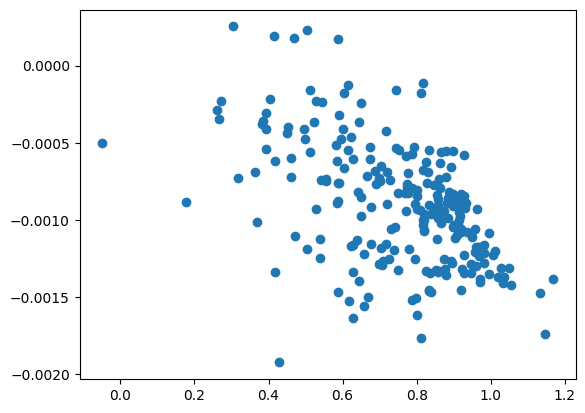

In [7]:
import matplotlib.pyplot as plt

plt.scatter(last_beta, last_alpha)